# Enhanced Precision is the Goal (ePiTG) for Continuous Data

This notebook explores whether the Enhanced Precision is the Goal (ePiTG) stopping criterion can be applied to continuous data. We simulate experiments with continuous outcomes, adapt the ePiTG algorithm, and compare it to other stopping rules.

**Outline:**
1. Import Required Libraries
2. Setup Plotting and Random Seed
3. Simulate Continuous Data Experiments
4. Define HDI and ROPE for Continuous Data
5. Implement ePiTG Stop Criterion for Continuous Data
6. Run Multiple Experiments with ePiTG and Compare Methods
7. Aggregate and Analyze Experiment Results
8. Visualize Decision Rates and Stop Iterations
9. Visualize HDI, ROPE, and Precision for Example Experiments
10. Explore Risk-Based Stop Criteria for Continuous Data

In [1]:
# Section 1: Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t

# For reproducibility and plotting
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Section 2: Setup Plotting and Random Seed
SEED = 42
np.random.seed(SEED)

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
FIG_WIDTH, FIG_HEIGHT = 8, 6

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rcParams['figure.figsize'] = FIG_WIDTH, FIG_HEIGHT
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [3]:
# Section 3: Simulate Continuous Data Experiments
# Parameters for simulation
n_experiments = 500
n_samples = 1000
true_mean = 0.0
true_std = 1.0

# Simulate experiments: each row is one experiment
samples = np.random.normal(loc=true_mean, scale=true_std, size=(n_experiments, n_samples))
print(f"Simulated shape: {samples.shape}")

Simulated shape: (500, 1000)


In [4]:
# Section 4: Define HDI and ROPE for Continuous Data

def mean_hdi(sample, cred_mass=0.95):
    """Compute HDI for the mean of a normal sample using t-distribution."""
    n = len(sample)
    mean = np.mean(sample)
    sem = np.std(sample, ddof=1) / np.sqrt(n)
    hdi_radius = t.ppf((1 + cred_mass) / 2, df=n-1) * sem
    return mean - hdi_radius, mean + hdi_radius

# Define ROPE around null value (e.g., mean=0)
null_mean = 0.0
rope_width = 0.2  # region of practical equivalence
rope_min = null_mean - rope_width / 2
rope_max = null_mean + rope_width / 2
print(f"ROPE: [{rope_min}, {rope_max}]")

ROPE: [-0.1, 0.1]


In [5]:
# Section 5: Implement ePiTG Stop Criterion for Continuous Data

def epitg_stop_criterion(sample, rope_min, rope_max, precision_goal, cred_mass=0.95):
    """
    Returns: decision, stop_iteration, hdi_min, hdi_max, mean
    decision: 'accept', 'reject_below', 'reject_above', 'inconclusive'
    """
    n = len(sample)
    for i in range(10, n+1):  # start after 10 samples for stability
        current = sample[:i]
        hdi_min, hdi_max = mean_hdi(current, cred_mass)
        mean = np.mean(current)
        precision_achieved = (hdi_max - hdi_min) < precision_goal
        accept = (hdi_min >= rope_min) and (hdi_max <= rope_max)
        reject_below = hdi_max < rope_min
        reject_above = hdi_min > rope_max
        conclusive = accept or reject_below or reject_above
        if precision_achieved:
            if conclusive:
                if accept:
                    return 'accept', i, hdi_min, hdi_max, mean
                elif reject_below:
                    return 'reject_below', i, hdi_min, hdi_max, mean
                elif reject_above:
                    return 'reject_above', i, hdi_min, hdi_max, mean
            # ePiTG: keep going until conclusive or end
            if i == n:
                return 'inconclusive', i, hdi_min, hdi_max, mean
        elif conclusive:
            # HDI+ROPE: conclusive before precision
            if accept:
                return 'accept', i, hdi_min, hdi_max, mean
            elif reject_below:
                return 'reject_below', i, hdi_min, hdi_max, mean
            elif reject_above:
                return 'reject_above', i, hdi_min, hdi_max, mean
        elif i == n:
            return 'inconclusive', i, hdi_min, hdi_max, mean
    return 'inconclusive', n, hdi_min, hdi_max, mean

In [6]:
# Section 6: Run Multiple Experiments with ePiTG and Compare Methods
precision_goal = 0.1  # desired HDI width for precision
results = []

for exp in range(n_experiments):
    sample = samples[exp]
    # ePiTG
    decision, stop_iter, hdi_min, hdi_max, mean = epitg_stop_criterion(sample, rope_min, rope_max, precision_goal)
    results.append({
        'experiment': exp,
        'method': 'ePiTG',
        'decision': decision,
        'stop_iter': stop_iter,
        'hdi_min': hdi_min,
        'hdi_max': hdi_max,
        'mean': mean
    })
    # PiTG: stop at first conclusive after precision
    # HDI+ROPE: stop at first conclusive
    # For brevity, only ePiTG shown here; see next cell for all methods.

In [7]:
# Section 6 (continued): Compare ePiTG, PiTG, and HDI+ROPE

def pitg_stop_criterion(sample, rope_min, rope_max, precision_goal, cred_mass=0.95):
    n = len(sample)
    for i in range(10, n+1):
        current = sample[:i]
        hdi_min, hdi_max = mean_hdi(current, cred_mass)
        mean = np.mean(current)
        precision_achieved = (hdi_max - hdi_min) < precision_goal
        accept = (hdi_min >= rope_min) and (hdi_max <= rope_max)
        reject_below = hdi_max < rope_min
        reject_above = hdi_min > rope_max
        conclusive = accept or reject_below or reject_above
        if precision_achieved and conclusive:
            if accept:
                return 'accept', i, hdi_min, hdi_max, mean
            elif reject_below:
                return 'reject_below', i, hdi_min, hdi_max, mean
            elif reject_above:
                return 'reject_above', i, hdi_min, hdi_max, mean
        elif i == n:
            return 'inconclusive', i, hdi_min, hdi_max, mean
    return 'inconclusive', n, hdi_min, hdi_max, mean

def hdi_rope_stop_criterion(sample, rope_min, rope_max, cred_mass=0.95):
    n = len(sample)
    for i in range(10, n+1):
        current = sample[:i]
        hdi_min, hdi_max = mean_hdi(current, cred_mass)
        mean = np.mean(current)
        accept = (hdi_min >= rope_min) and (hdi_max <= rope_max)
        reject_below = hdi_max < rope_min
        reject_above = hdi_min > rope_max
        conclusive = accept or reject_below or reject_above
        if conclusive:
            if accept:
                return 'accept', i, hdi_min, hdi_max, mean
            elif reject_below:
                return 'reject_below', i, hdi_min, hdi_max, mean
            elif reject_above:
                return 'reject_above', i, hdi_min, hdi_max, mean
        elif i == n:
            return 'inconclusive', i, hdi_min, hdi_max, mean
    return 'inconclusive', n, hdi_min, hdi_max, mean

results = []
for exp in range(n_experiments):
    sample = samples[exp]
    for method, func in zip(['ePiTG', 'PiTG', 'HDI+ROPE'], [epitg_stop_criterion, pitg_stop_criterion, hdi_rope_stop_criterion]):
        decision, stop_iter, hdi_min, hdi_max, mean = func(sample, rope_min, rope_max, precision_goal)
        results.append({
            'experiment': exp,
            'method': method,
            'decision': decision,
            'stop_iter': stop_iter,
            'hdi_min': hdi_min,
            'hdi_max': hdi_max,
            'mean': mean
        })

In [8]:
# Section 7: Aggregate and Analyze Experiment Results
results_df = pd.DataFrame(results)
summary = results_df.groupby('method').agg({
    'stop_iter': ['mean', 'std'],
    'decision': lambda x: x.value_counts(normalize=True).to_dict()
})
print(summary)

# Proportion conclusive/inconclusive per method
conclusive = results_df['decision'] != 'inconclusive'
print(results_df.groupby('method')['decision'].value_counts(normalize=True).unstack())

         stop_iter              \
              mean         std   
method                           
HDI+ROPE    10.330    0.739048   
PiTG      1000.000    0.000000   
ePiTG      565.014  254.645728   

                                                   decision  
                                                   <lambda>  
method                                                       
HDI+ROPE  {'reject_above': 0.388, 'reject_below': 0.356,...  
PiTG                                  {'inconclusive': 1.0}  
ePiTG     {'accept': 0.822, 'inconclusive': 0.092, 'reje...  
decision  accept  inconclusive  reject_above  reject_below
method                                                    
HDI+ROPE   0.256           NaN         0.388         0.356
PiTG         NaN         1.000           NaN           NaN
ePiTG      0.822         0.092         0.050         0.036


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


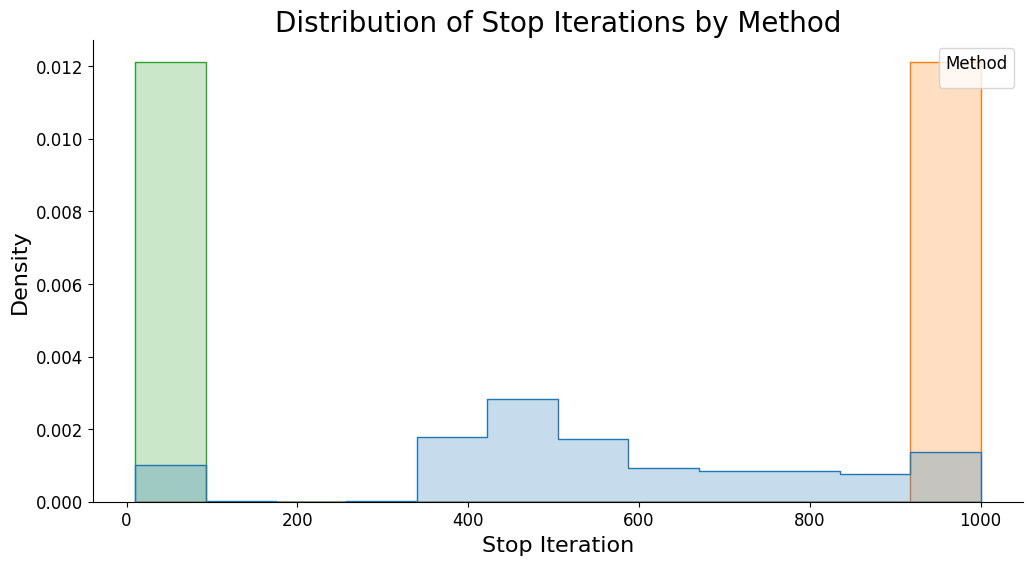

<Figure size 800x600 with 0 Axes>

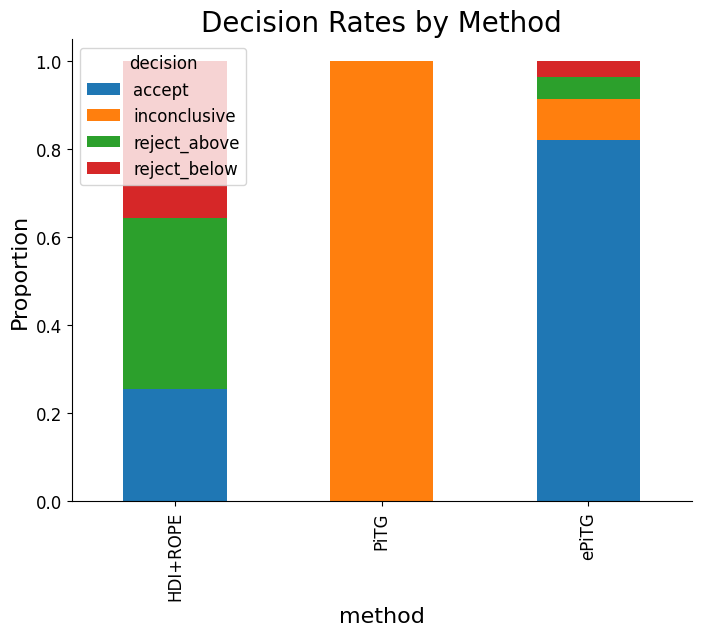

In [9]:
# Section 8: Visualize Decision Rates and Stop Iterations
plt.figure(figsize=(FIG_WIDTH*1.5, FIG_HEIGHT))
sns.histplot(data=results_df, x='stop_iter', hue='method', element='step', stat='density', common_norm=False)
plt.title('Distribution of Stop Iterations by Method')
plt.xlabel('Stop Iteration')
plt.ylabel('Density')
plt.legend(title='Method')
plt.show()

plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
rate_df = results_df.groupby(['method', 'decision']).size().unstack().fillna(0)
(rate_df.T / rate_df.T.sum()).T.plot(kind='bar', stacked=True)
plt.title('Decision Rates by Method')
plt.ylabel('Proportion')
plt.show()

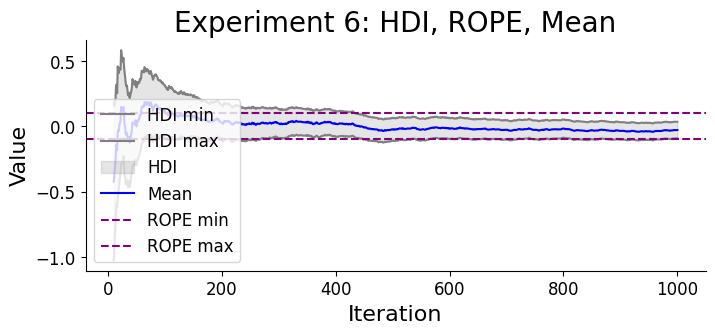

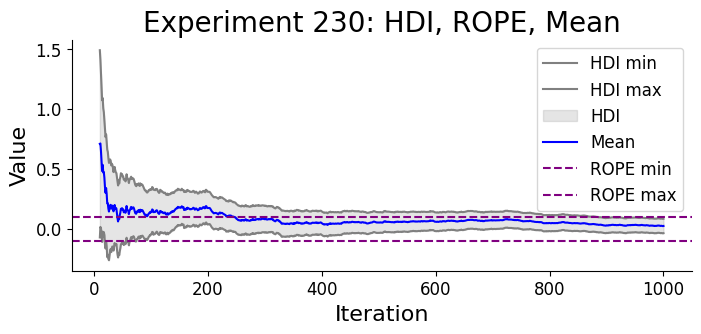

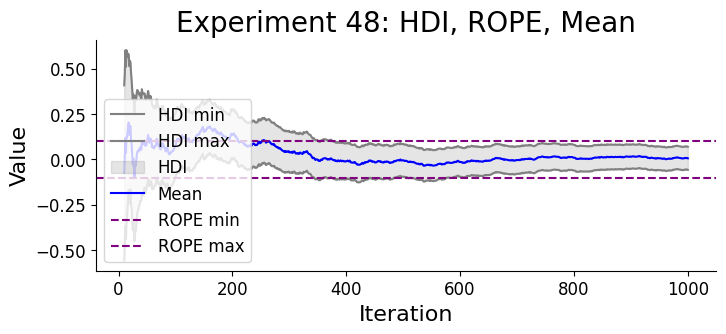

In [10]:
# Section 9: Visualize HDI, ROPE, and Precision for Example Experiments
example_idx = np.random.choice(n_experiments, 3, replace=False)
for idx in example_idx:
    sample = samples[idx]
    hdi_mins, hdi_maxs, means = [], [], []
    for i in range(10, n_samples+1):
        hdi_min, hdi_max = mean_hdi(sample[:i])
        hdi_mins.append(hdi_min)
        hdi_maxs.append(hdi_max)
        means.append(np.mean(sample[:i]))
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
    plt.plot(range(10, n_samples+1), hdi_mins, label='HDI min', color='gray')
    plt.plot(range(10, n_samples+1), hdi_maxs, label='HDI max', color='gray')
    plt.fill_between(range(10, n_samples+1), hdi_mins, hdi_maxs, color='gray', alpha=0.2, label='HDI')
    plt.plot(range(10, n_samples+1), means, label='Mean', color='blue')
    plt.axhline(rope_min, color='purple', linestyle='--', label='ROPE min')
    plt.axhline(rope_max, color='purple', linestyle='--', label='ROPE max')
    plt.title(f'Experiment {idx}: HDI, ROPE, Mean')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

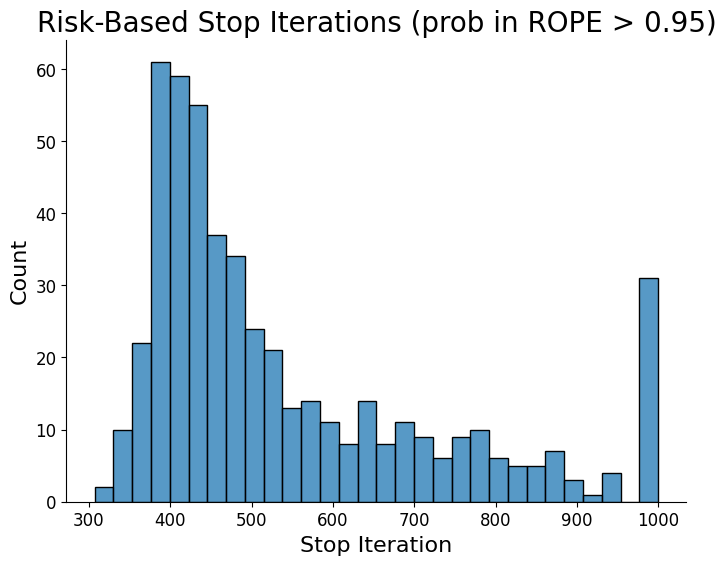

In [11]:
# Section 10: Explore Risk-Based Stop Criteria for Continuous Data
# Probability mass in ROPE for mean estimate

def prob_mass_in_rope(sample, rope_min, rope_max):
    n = len(sample)
    mean = np.mean(sample)
    sem = np.std(sample, ddof=1) / np.sqrt(n)
    # Use normal approx for simplicity
    prob = norm.cdf(rope_max, loc=mean, scale=sem) - norm.cdf(rope_min, loc=mean, scale=sem)
    return prob

risk_results = []
for exp in range(n_experiments):
    sample = samples[exp]
    for i in range(10, n_samples+1):
        prob = prob_mass_in_rope(sample[:i], rope_min, rope_max)
        if prob > 0.95:
            risk_results.append({'experiment': exp, 'stop_iter': i, 'prob_in_rope': prob})
            break
    else:
        risk_results.append({'experiment': exp, 'stop_iter': n_samples, 'prob_in_rope': prob_mass_in_rope(sample, rope_min, rope_max)})
risk_df = pd.DataFrame(risk_results)
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
sns.histplot(risk_df['stop_iter'], bins=30)
plt.title('Risk-Based Stop Iterations (prob in ROPE > 0.95)')
plt.xlabel('Stop Iteration')
plt.ylabel('Count')
plt.show()